In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

import matplotlib as mpl

from abianalysis.volume import Volume
from abianalysis.volume.preprocess import match_genes
from abianalysis.hierarchy import make_hierarchy
from abianalysis.hierarchy.matching import rotate_to_match,\
    match_voxels_to_hierarchy_nodes, score_voxel_to_hierarchy_match
from pylineage.layout import h_tree_layout, tree_layout
from pylineage.color import TreeColorMap
from abianalysis.plot.side import Side
from abianalysis.plot.max_projection import MaxProjection
from abianalysis.plot.hierarchy_plotter import plot_tree

from utils import *

import inspect
from math import ceil
from tqdm import tqdm

In [2]:
SOURCE_AGE = 'P28'
TARGET_AGES = ['E11.5', 'E13.5', 'E15.5', 'E18.5', 
               'P4', 'P14', 'P28', 'P56']

volumes = {
    **{age: load_volume(age) for age in TARGET_AGES},
    'Shuffled': load_volume(SOURCE_AGE, shuffled=True)
}

In [3]:
%%time
hierarchies = {
    **{age: load_hierarchy(age) for age in TARGET_AGES},
    'Shuffled': load_hierarchy(SOURCE_AGE, shuffled=True)
}

CPU times: user 8.68 s, sys: 522 ms, total: 9.21 s
Wall time: 9.73 s


In [4]:
%%time
source_hierarchy = hierarchies[SOURCE_AGE]
matches = dict()
for age, target_hierarchy in hierarchies.items():
    rotate_to_match(source_hierarchy, target_hierarchy)
    exp = target_hierarchy.volume.expression
    src = match_voxels_to_hierarchy_nodes(source_hierarchy, exp)
    tar = match_voxels_to_hierarchy_nodes(target_hierarchy, exp)
    matches[age] = tar, src

CPU times: user 7min 42s, sys: 6min 26s, total: 14min 9s
Wall time: 2min 11s


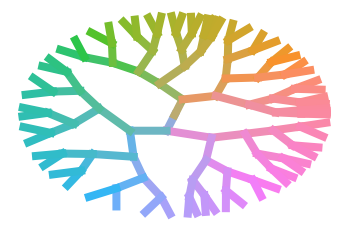

In [5]:
fig, ax = plt.subplots()
plot_tree(ax, source_hierarchy, depth=7, lw=8, s=0)
ax.axis('off');

Small possible differences are due to arbitrariness. When there is an equal count of nodes in one pixel, both are equally valid.

CPU times: user 8.07 s, sys: 152 ms, total: 8.22 s
Wall time: 7.83 s


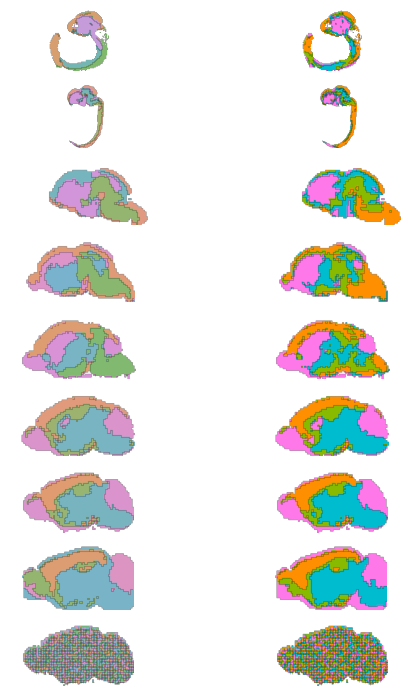

In [6]:
%%time
fig = plt.figure(figsize=(8, 12),dpi=75)
spec = fig.add_gridspec(ncols=2, 
                        nrows=len(hierarchies), 
                        width_ratios=[1, 1])

depth = 2
color = TreeColorMap().get_color_map(source_hierarchy, depth=depth)

for i, (target_age, hierarchy) in enumerate(hierarchies.items()):    
    target_volume = hierarchy.volume

    original, match = matches[target_age]
    
    ax = fig.add_subplot(spec[i, 0])
    ax.axis(False)

    stack = MaxProjection.from_leaves(original, depth, Side.SAGITTAL)
    ax.imshow(stack.to_image(TreeColorMap().get_color_map(hierarchies[target_age])))
    ax.add_collection(stack.get_outlines())
    
    ax = fig.add_subplot(spec[i, 1])
    ax.axis(False)
    stack = MaxProjection.from_leaves(match, depth, Side.SAGITTAL, 
                                      pos=[h.volume_index for h in original])
    ax.imshow(stack.to_image(color))
    ax.add_collection(stack.get_outlines())

fig.savefig('project_2d.pdf', transparent=True, dpi=300)

In [7]:
scores = {}

depth = 3
for source_age in tqdm(volumes):
    source_hierarchy = hierarchies[source_age]
    matches = dict()
    for age, target_volume in volumes.items():
        target_hierarchy = hierarchies[age]
        matches[age] = (
            match_voxels_to_hierarchy_nodes(source_hierarchy, target_volume.expression),
            match_voxels_to_hierarchy_nodes(target_hierarchy, target_volume.expression)
        )
    
    sc = []
    for age in volumes:
        original, match = matches[age]
        node_map = rotate_to_match(source_hierarchy, hierarchies[age])
        sc.append(score_voxel_to_hierarchy_match(original, match, node_map))
    
    scores[source_age] = sc

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:17<00:00, 28.60s/it]


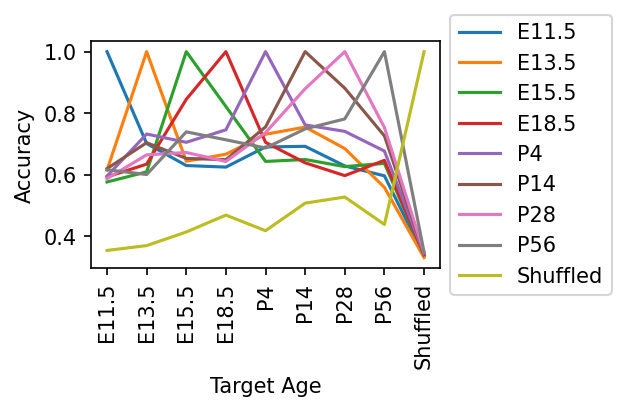

In [8]:
fig, ax = plt.subplots(figsize=(3,2), dpi=150)

x = np.arange(len(scores))
for age, sc in scores.items():
    ax.plot(sc, '-', label=age)

ax.set_xticks(range(len(scores)))
ax.set_xticklabels(list(volumes), rotation=90)
ax.set_xlabel('Target Age')
ax.set_ylabel('Accuracy')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
fig.savefig('project_quant.pdf')

In [9]:
%%time
source_hierarchy = hierarchies[SOURCE_AGE]
scores = []
for d in range(7):
    matches = dict()
    for age, target_volume in volumes.items():
        target_hierarchy = hierarchies[age]
        matches[age] = (
            match_voxels_to_hierarchy_nodes(source_hierarchy, target_volume.expression),
            match_voxels_to_hierarchy_nodes(target_hierarchy, target_volume.expression)
        )
        
    sc = []
    for age in volumes:
        original, match = matches[age]
        node_map = rotate_to_match(source_hierarchy, hierarchies[age])
        sc.append(score_voxel_to_hierarchy_match(original, match, node_map, depth=d))
    scores.append(sc)

CPU times: user 15min 28s, sys: 14min 51s, total: 30min 19s
Wall time: 3min 21s


(0.0, 1.1)

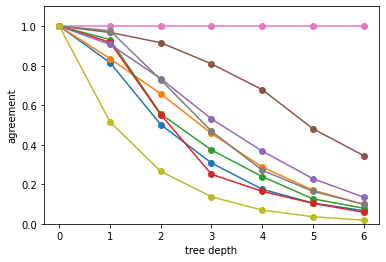

In [10]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(np.array(scores), '-o')
ax.set_xlabel('tree depth')
ax.set_ylabel('agreement')
ax.set_ylim([0, 1.1])